In [9]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [10]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class TRPO:
    """ TRPO算法 """
    def __init__(self,hidden_dim, state_space, action_space, lmbda, kl_constraint, alpha,
                critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action_probs = self.actor(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample() #按概率采样
        return action.item()
    
    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        """
        为了避免大矩阵的出现,我们只计算向量H*x,而不直接计算和存储矩阵
        """
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists,new_action_dists))
        #计算KL散度的一阶梯度 
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True) #保留计算图以支持二阶导数
        #将梯度展平成向量
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        #KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        #计算黑塞矩阵与向量的乘积
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])

        return grad2_vector
    
    def conjugate_gradient(self, grad , states, old_action_dists):
        """ 共轭梯度法求方程 """
        x = torch.zeros_like(grad)      #方程解 H^(-1) * g
        r = grad.clone()                #初始残差
        p = grad.clone()                #初始搜索方向
        rdotr = torch.dot(r,r)          #初始化残差内积, 用于计算步长alpha

        for _ in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r,r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr

        return x
    
    def compute_surrogate_obj(self, states,actions, advantage, old_log_probs, actor):
        """ 计算策略目标 L(theta_old) """
        log_probs = torch.log(actor(states).gather(1,actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)
    
    def line_search(self, states , actions, advantage, old_log_probs, old_action_dists,max_vec):
        """
        线性搜索:
        目的是找到最长的步长alpha, 使得沿自然梯度方向更新后满足优化方程 
        """
        #将网络参数转换成一个single vector
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        #计算当前策略的目标函数的值
        old_obj  = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        for i in range(15): #尝试15次衰减步长
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            #生成新策略并计算KL散度
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_actor_dists = torch.distributions.Categorical(new_actor(states))
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_actor_dists))
            new_obj = self.compute_surrogate_obj(states,actions,advantage,old_log_probs,new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para
    
    def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):
        """ 更新actor网络参数 """
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                     old_action_dists,descent_direction * max_coef)
        #用线性搜索后的参数更新策略
        torch.nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())
        
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        #时序差分目标(优势函数)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        #广义优势估计
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device) 
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())

        critic_loss = torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数 <- actor 网络参数更新
        self.policy_learn(states, actions, old_action_dists, old_log_probs,advantage) 


Iteration 9: 100%|██████████| 120/120 [01:23<00:00,  1.44it/s, episode=1200, return=500.000]


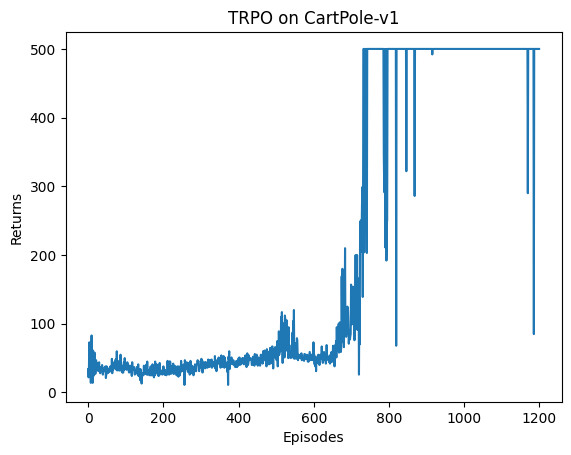

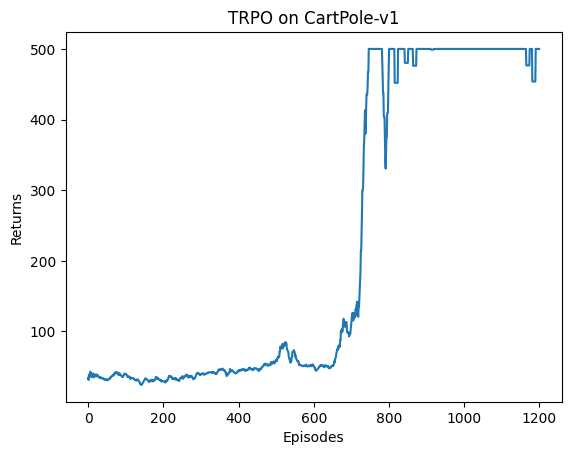

In [24]:
#初始参数需要1800个episodes才收敛
num_episodes = 1200
hidden_dim = 128
gamma = 0.995   #改为0.99之后1600个episodes收敛 
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.001 #改为0.005之后无法收敛,return只有50. 改为0.001后1250episodes收敛
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)

torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

### 尝试总结今天所学

1. 学习TRPO可以改善在策略学习中突然的性能下降问题. 通过在一个性能肯定上升的信任区域内更新, 来达到性能稳步上升的效果.
   
2. 信任区域, 也就是在更新时序差分目标(优势函数)的基础上增加了一个约束. 线性近似, 共轭梯度, 矩阵展平都是数学手段. 方便求解目标函数.
   
3. 与actor-critic章节的方法最大的区别就是actor网络参数的更新(依赖信任区域).

4. TRPO的核心优势在于解决复杂任务中的策略更新稳定性问题，例如：
   + 高维/连续动作空间（如MuJoCo任务）。
   + 稀疏奖励（如Atari游戏中的长期目标）。
   + 策略易崩溃场景（如机械臂控制中的危险动作）。



---



#### 1. **TRPO的核心改进**
- **信任区域约束**：通过限制新旧策略的KL散度，确保策略更新幅度在安全范围内，避免性能崩溃：
  $$
  \text{最大化} \quad L(\theta) \quad \text{约束} \quad \bar{D}_{KL}(\pi_{\theta_{\text{old}}} \| \pi_\theta) \leq \delta
  $$
- **理论保证**：
  - 基于策略性能下界（Surrogate Objective）的数学推导，证明在KL散度约束下，策略改进是单调的。
  - 对比传统策略梯度（如REINFORCE）：直接最大化期望回报但步长敏感，TRPO通过约束更新幅度避免灾难性更新。

---

#### 2. **信任区域与数学手段**
##### **KL散度的方向与近似**
- **约束方向**：严格限定为 $  D_{KL}(\pi_{\text{old}} \| \pi_{\text{new}})  $，反向会导致理论失效。
- **泰勒展开近似**：
  - 目标函数一阶近似：
    $$
    L(\theta) \approx g^T (\theta - \theta_{\text{old}}), \quad g = \nabla_\theta L(\theta) \big|_{\theta = \theta_{\text{old}}}
    $$
  - KL散度二阶近似：
    $$
    \bar{D}_{KL} \approx \frac{1}{2} (\theta - \theta_{\text{old}})^T H (\theta - \theta_{\text{old}})
    $$

##### **共轭梯度法的作用**
- **避免显式计算Hessian矩阵**：仅需计算Hessian-vector乘积 $  Hv  $，适合高维参数空间：
  $$
  Hv = \nabla_\theta \left( \nabla_\theta D_{KL} \cdot v \right)
  $$
- **参数展平**：将网络参数展平为向量，便于处理梯度与Hessian运算。

---

#### 3. **与Actor-Critic的区别**
##### **Critic网络的相同点**
- 价值网络（Critic）使用常规梯度下降更新，与Actor-Critic一致。

##### **Actor更新的本质区别**
- **Actor-Critic**：
  - 直接沿策略梯度方向更新，步长由学习率控制。
  - 数学形式：$  \theta_{\text{new}} = \theta_{\text{old}} + \alpha g  $。

- **TRPO**：
  - 沿自然梯度方向更新，步长由KL约束和线性搜索动态确定。
  - 数学形式：$  \theta_{\text{new}} = \theta_{\text{old}} + \alpha H^{-1}g  $。

##### **自然梯度的几何意义**
- 在参数空间的黎曼流形中，考虑曲率信息（Hessian矩阵 $  H  $），使更新方向更符合策略分布的几何特性。

---

#### 4. **关键实现细节**
##### **线性搜索（Line Search）**
- **作用**：在理论最大步长 $  \alpha_{\text{max}} = \sqrt{\frac{2\delta}{x^T H x}}  $ 基础上，按衰减系数（如0.5）缩小步长，直到满足：
  $$
  L(\theta_{\text{new}}) > L(\theta_{\text{old}}) \quad \text{且} \quad \bar{D}_{KL} \leq \delta
  $$

##### **替代目标函数设计**
- 数学形式：
  $$
  L(\theta) = \mathbb{E}_{s \sim \pi_{\text{old}}, a \sim \pi_{\text{old}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\text{old}}}(s, a) \right]
  $$
- **重要性采样**：通过旧策略样本估计新策略期望，实现离线策略优化。

##### **数值稳定性措施**
- **Hessian-vector乘积扰动**：添加微小值 $  1e-8  $ 防止除零或负特征值：
  $$
  \text{实际步长} \quad \alpha = \frac{r_{\text{dot}r}}{p^T Hp + 1e-8}
  $$
- **KL散度截断**：当 $  \bar{D}_{KL} > 2\delta  $ 时拒绝更新。

---

#### 5. **常见误区修正**
##### **误区1：信任区域直接约束优势函数**
- **修正**：约束作用于策略分布的KL散度，而非优势函数：
  $$
  \text{约束条件} \quad \bar{D}_{KL}(\pi_{\text{old}} \| \pi_{\text{new}}) \leq \delta
  $$

##### **误区2：共轭梯度法直接优化目标**
- **修正**：共轭梯度法用于求解线性方程组 $  Hx = g  $，不直接优化目标函数。

---

#### 6. **总结**
TRPO通过**信任区域约束**和**自然梯度更新**解决了策略学习的稳定性问题：
1. **数学保证**：KL散度约束确保策略性能单调提升。
2. **高效计算**：共轭梯度法避免显式求逆，适合高维参数。
3. **实践平衡**：线性搜索与数值稳定性措施保障算法鲁棒性。
